In [2]:
# Cell 1 — Import libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

RSEED = 42
np.random.seed(RSEED)


In [3]:
# Cell 2 — Load dataset
df = pd.read_csv("C:\\Users\\User\\Desktop\\Assignments\\LAST SEM!!\\Machine Learning\\GiveMeSomeCredit\\cs-training.csv")   # <-- change path if needed


# Some versions of this dataset have an "Unnamed: 0" index column. Drop it.
if 'Unnamed: 0' in df.columns:
    df = df.rename(columns={'Unnamed: 0':'Id'}).drop(columns=['Id'])

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (150000, 11)


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


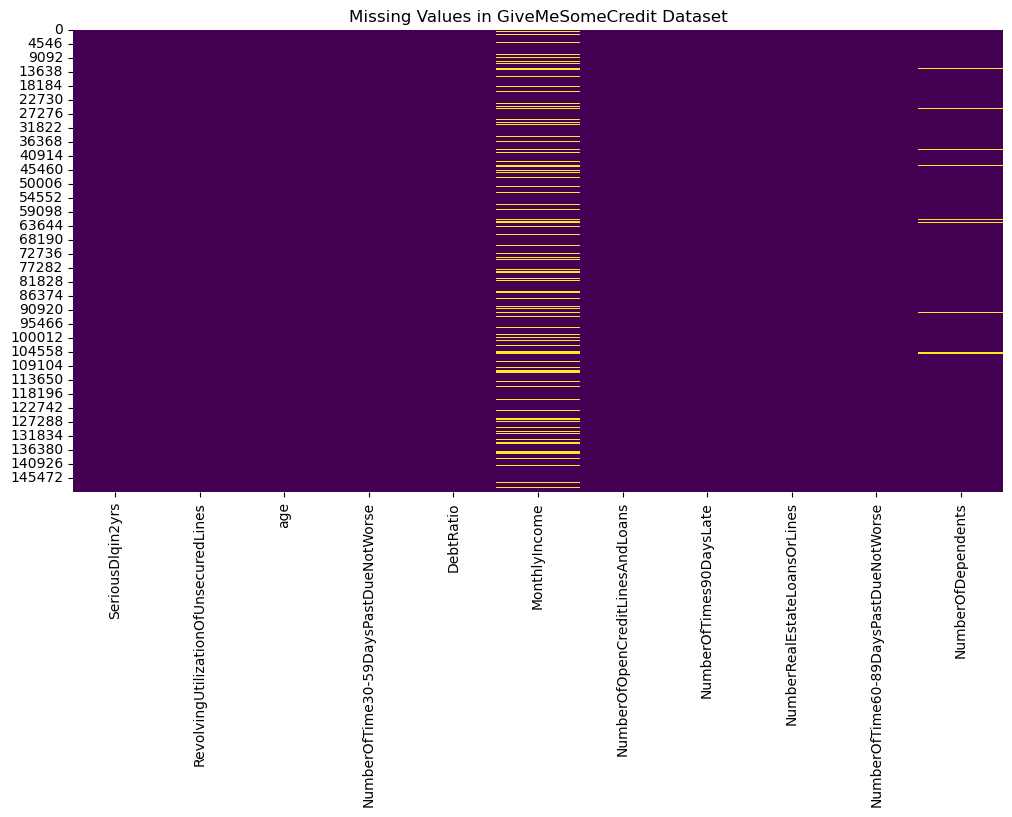

Top 10 features with most missing values:
MonthlyIncome                           29731
NumberOfDependents                       3924
SeriousDlqin2yrs                            0
age                                         0
RevolvingUtilizationOfUnsecuredLines        0
DebtRatio                                   0
NumberOfTime30-59DaysPastDueNotWorse        0
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
dtype: int64


In [4]:
# 🔎 Missing values heatmap (GiveMeSomeCredit)
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in GiveMeSomeCredit Dataset')
plt.show()

print("Top 10 features with most missing values:")
print(df.isnull().sum().sort_values(ascending=False).head(10))


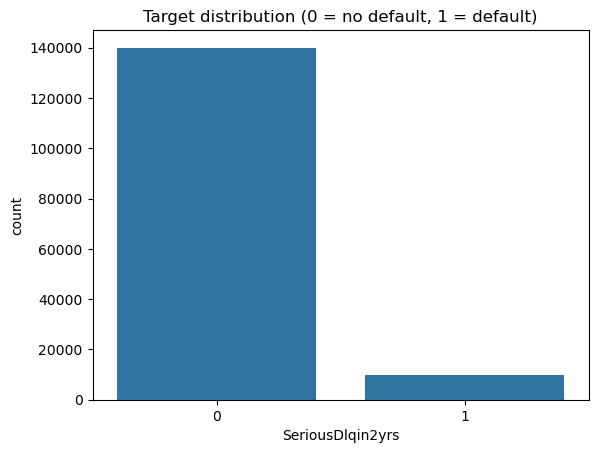

Class distribution (%):
SeriousDlqin2yrs
0    93.316
1     6.684
Name: proportion, dtype: float64


In [5]:
# Cell 3 — Check class distribution (imbalance check)
sns.countplot(x='SeriousDlqin2yrs', data=df)
plt.title('Target distribution (0 = no default, 1 = default)')
plt.show()

print("Class distribution (%):")
print(df['SeriousDlqin2yrs'].value_counts(normalize=True)*100)


In [6]:
# Cell 4 — Separate features and target + preprocessing setup
y = df['SeriousDlqin2yrs']             # Target variable: credit default (0/1)
X = df.drop(columns=['SeriousDlqin2yrs'])

# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Numeric pipeline: fill missing with median + scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: fill missing with "Missing" + one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])


In [7]:
# Cell 5 — Train/test split (stratify to preserve class imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RSEED
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (120000, 10)
Test shape: (30000, 10)


In [8]:
# Cell 6 — Random Forest Classifier with SMOTE to balance classes
from sklearn.metrics import classification_report
smote = SMOTE(random_state=RSEED)

pipe_rf = ImbPipeline(steps=[
    ('pre', preprocessor),                  # preprocessing (scaling + encoding)
    ('smote', smote),                       # oversample minority class
    ('clf', RandomForestClassifier(random_state=RSEED, n_jobs=-1))   # RF model
])

# Hyperparameter search space
param_rf = {
    'clf__n_estimators': [200, 500],        # number of trees
    'clf__max_depth': [6, 10, None],        # tree depth
    'clf__min_samples_split': [2, 5, 10]    # minimum samples per split
}

# Randomized search (faster than grid search)
rs_rf = RandomizedSearchCV(pipe_rf, param_rf, n_iter=5,
                           cv=StratifiedKFold(4),
                           scoring='roc_auc',
                           n_jobs=-1,
                           random_state=RSEED)

# Train model
rs_rf.fit(X_train, y_train)
pred_rf = rs_rf.predict(X_test)

# Evaluate on test set
print("Best RF params:", rs_rf.best_params_)

#Table form
report_rf = classification_report(y_test, pred_rf, output_dict=True)
df_report_rf = pd.DataFrame(report_rf).transpose()
df_report_rf["ROC-AUC"] = ["", "", "", "", roc_auc_score(y_test, rs_rf.predict_proba(X_test)[:,1])]
display(df_report_rf)

Best RF params: {'clf__n_estimators': 200, 'clf__min_samples_split': 2, 'clf__max_depth': 6}


,precision,recall,f1-score,support,ROC-AUC
0,0.975335,0.841865,0.903698,27995.000000,
1,0.241432,0.702743,0.359393,2005.000000,
accuracy,0.832567,0.832567,0.832567,0.832567,
macro avg,0.608384,0.772304,0.631546,30000.000000,
weighted avg,0.926286,0.832567,0.867321,30000.000000,0.858048


In [9]:
# Cell 7 — XGBoost Classifier
# Compute class imbalance ratio
neg, pos = (y_train==0).sum(), (y_train==1).sum()
scale_pos_weight = neg/pos

pipe_xgb = Pipeline(steps=[
    ('pre', preprocessor),   # preprocessing
    ('clf', xgb.XGBClassifier(random_state=RSEED,
                              scale_pos_weight=scale_pos_weight,
                              use_label_encoder=False,
                              eval_metric='logloss'))
])

# Hyperparameter search space
param_xgb = {
    'clf__n_estimators': [200, 400],        # number of boosting rounds
    'clf__max_depth': [3, 5, 7],            # tree depth
    'clf__learning_rate': [0.01, 0.05, 0.1] # learning rate
}

# Randomized search
rs_xgb = RandomizedSearchCV(pipe_xgb, param_xgb, n_iter=5,
                            cv=StratifiedKFold(4),
                            scoring='roc_auc',
                            n_jobs=-1,
                            random_state=RSEED)

# Train model
rs_xgb.fit(X_train, y_train)
pred_xgb = rs_xgb.predict(X_test)

# Evaluate on test set
report_xgb = classification_report(y_test, pred_xgb, output_dict=True)
df_report_xgb = pd.DataFrame(report_xgb).transpose()
df_report_xgb["ROC-AUC"] = ["", "", "", "", roc_auc_score(y_test, rs_xgb.predict_proba(X_test)[:,1])]
display(df_report_xgb)

,precision,recall,f1-score,support,ROC-AUC
0,0.980464,0.801357,0.881909,27995.000000,
1,0.218851,0.777057,0.341517,2005.000000,
accuracy,0.799733,0.799733,0.799733,0.799733,
macro avg,0.599658,0.789207,0.611713,30000.000000,
weighted avg,0.929563,0.799733,0.845793,30000.000000,0.868526


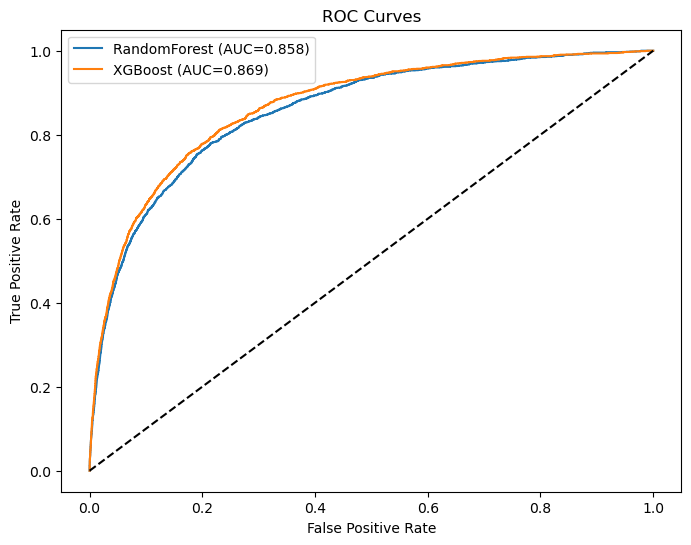

In [10]:
# Cell 8 — Plot ROC curves for both models
plt.figure(figsize=(8,6))

models = {
    'RandomForest': rs_rf.best_estimator_,
    'XGBoost': rs_xgb.best_estimator_
}

for name, model in models.items():
    prob = model.predict_proba(X_test)[:,1]   # probability of class 1
    fpr, tpr, _ = roc_curve(y_test, prob)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})")

plt.plot([0,1],[0,1],'k--')   # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


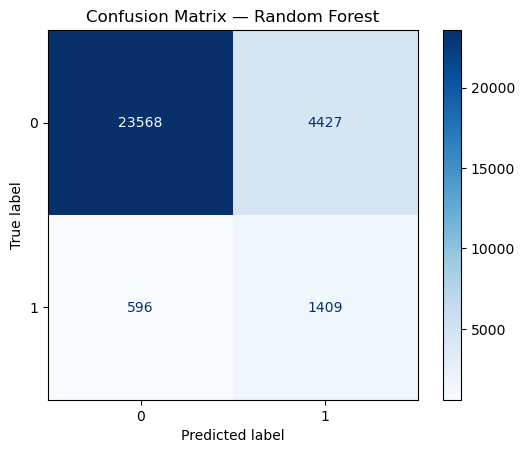

In [11]:
# Cell 9 — Confusion matrix to see predictions
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred_rf)
disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix — Random Forest")
plt.show()
